In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
image_transforms  = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees = 45),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# dataset = 'E:\gmd_data\microsphere2_dataAugmented'
dataset = 'E:\gmd_data\\2022_05_17_05_DataSet'
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

batch_size = 32
# num_classes = 173

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

}


train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

print(train_data_size, valid_data_size)

37560 6260


迁移学习
---------


这里使用ResNet-50的预训练模型。


In [5]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = True

fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 626),
    nn.LogSoftmax(dim = 1)


)
resnet50 = resnet50.to('cuda:0')
loss_func = nn.NLLLoss()
# optimizer = optim.AdamW(resnet50.parameters(),lr=1e-4)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
model = resnet50
loss_function = loss_func
epochs = 3000
LR_value = 1e-4
# trained_model, history = train_and_valid(resnet50, loss_func, num_epochs)
# torch.save(history, 'models/'+dataset+'_history.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0

for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
#         学习率递减
    if epoch <= 10:
        LR = LR_value;
    elif epoch <= 20:
        LR = LR_value*0.5;
    elif epoch <= 30:
        LR = LR_value*0.5*0.5;
    elif epoch <= 40:
        LR = LR_value*0.5*0.5*0.5;
    else:
        LR = LR_value*0.5*0.5*0.5*0.5;
    optimizer = optim.AdamW(resnet50.parameters(),lr=LR)

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        #因为这里梯度是累加的，所以每次记得清零
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        loss.backward()

        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        train_acc += acc.item() * inputs.size(0)

    with torch.no_grad():
        model.eval()

        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_function(outputs, labels)

            valid_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            valid_acc += acc.item() * inputs.size(0)

    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/train_data_size

    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/valid_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    if best_acc < avg_valid_acc:
        best_acc = avg_valid_acc
        best_epoch = epoch + 1

    epoch_end = time.time()

    print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
        epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
    ))
    print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))

    torch.save(model, dataset+'/models/'+'model_'+str(epoch+1)+'.pt')


Epoch: 1/3000
Epoch: 001, Training: Loss: 5.4325, Accuracy: 0.9132%, 
		Validation: Loss: 14.9632, Accuracy: 0.1597%, Time: 1398.2532s
Best Accuracy for validation : 0.0016 at epoch 001
Epoch: 2/3000
Epoch: 002, Training: Loss: 4.3740, Accuracy: 2.1486%, 
		Validation: Loss: 18.0042, Accuracy: 0.1917%, Time: 459.4596s
Best Accuracy for validation : 0.0019 at epoch 002
Epoch: 3/3000
Epoch: 003, Training: Loss: 4.0492, Accuracy: 2.8408%, 
		Validation: Loss: 10.8129, Accuracy: 0.1597%, Time: 1152.6952s
Best Accuracy for validation : 0.0019 at epoch 002
Epoch: 4/3000
Epoch: 004, Training: Loss: 3.8828, Accuracy: 3.2934%, 
		Validation: Loss: 15.5962, Accuracy: 0.1597%, Time: 1816.5051s
Best Accuracy for validation : 0.0019 at epoch 002
Epoch: 5/3000
Epoch: 005, Training: Loss: 3.7552, Accuracy: 3.8605%, 
		Validation: Loss: 12.0607, Accuracy: 0.1597%, Time: 1781.7942s
Best Accuracy for validation : 0.0019 at epoch 002
Epoch: 6/3000
Epoch: 006, Training: Loss: 3.6689, Accuracy: 4.0256%, 
	

KeyboardInterrupt: 

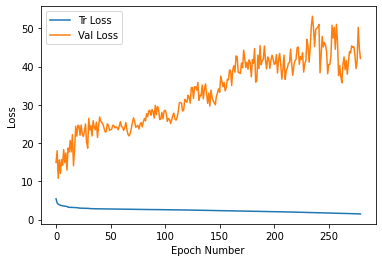

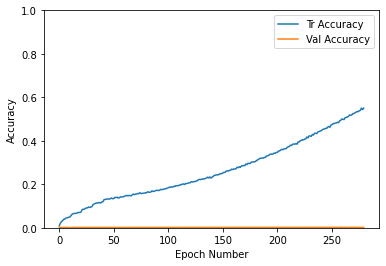

In [8]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

plt.plot(history[:, 2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

导入模型 将验证集和真值对比图画出来
-------

In [5]:
# 导入模型 将验证集和真值对比图画出来
# dataset = 'E:\gmd_data\microsphere2_dataAugmented'
model38 = torch.load( dataset+'/models/'+'model_260.pt')
for param in model38.parameters():
    param.requires_grad = False
model38 = model38.to('cuda:0')
loss_function = nn.NLLLoss()



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0


valid_loss = 0.0
valid_acc = 0.0

predictions_all = torch.tensor([]).to(device)
labels_all = torch.tensor([]).to(device)

for j, (inputs, labels) in enumerate(valid_data):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model38(inputs)

    loss = loss_function(outputs, labels)
    # print("valid_data_j: {}".format(j))
    # print("Outputs : ")
    # print(outputs)
    # print("labels ：")
    # print(labels)
    # print("loss ：")
    # print(loss)

    valid_loss += loss.item() * inputs.size(0)

    ret, predictions = torch.max(outputs.data, 1)

    predictions_all = torch.cat((predictions_all,predictions),dim=0)
    labels_all = torch.cat((labels_all,labels),dim=0)

    correct_counts = predictions.eq(labels.data.view_as(predictions))

    acc = torch.mean(correct_counts.type(torch.FloatTensor))

    valid_acc += acc.item() * inputs.size(0)

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

验证集 结果：准确率、误差图像
-

Validation: Loss: 37.6590, Accuracy: 0.3035%
Validation: MAE: 4.4762, Percentage of points retained:4.3610% 


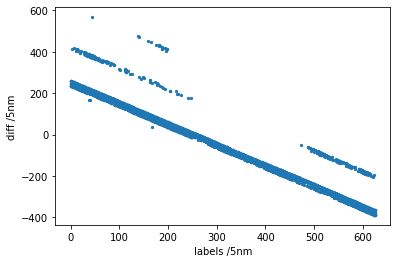

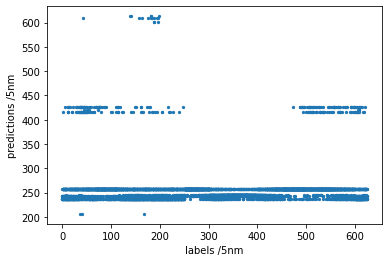

In [8]:
history.append([avg_valid_loss, avg_valid_acc])

print("Validation: Loss: {:.4f}, Accuracy: {:.4f}%".format(
    avg_valid_loss, avg_valid_acc*100
))
# print("Validation: MSE: {:.4f}".format( ))

diff = predictions_all - labels_all
# conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)
device = torch.device("cpu")
diff_small = diff[(diff>-10)&(diff<10)].to(device)
diff_rate = len(diff_small)/len(diff)
DIFF_MAE = np.linalg.norm(diff_small, ord = 1) / len(diff_small)
print("Validation: MAE: {:.4f}, Percentage of points retained:{:.4f}% ".format(
    DIFF_MAE, diff_rate*100
    ))

fig, ax = plt.subplots()
plt.scatter(labels_all[0:50000].cpu(),diff[0:50000].cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels /5nm')
plt.ylabel('diff /5nm')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()
fig.savefig('Diff_2022_05_17_05_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')

fig, ax = plt.subplots()
plt.scatter(labels_all[0:50000].cpu(),predictions_all[0:50000].cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels /5nm')
plt.ylabel('predictions /5nm')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()
fig.savefig('Predictions_2022_05_17_05_16_step5_cut3DataSet.svg',dpi = 300, format = 'svg')


测试组：用未训练的 0104-2组 进行测试
-

Validation: valid_data_size: 1060.0000
Validation: Loss: 931.1962, Accuracy: 0.0000%


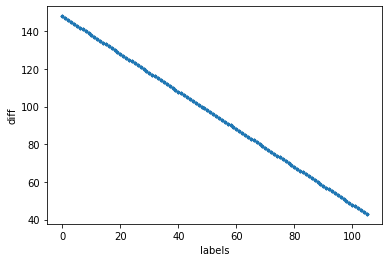

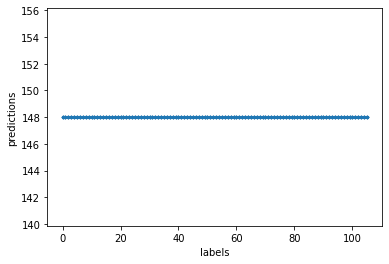

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
image_transforms  = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees = 45),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# dataset = 'E:\gmd_data\microsphere2_dataAugmented'
dataset = 'E:\gmd_data\GMD_0104_2_DATA' # 测试集 0104-2
# dataset = 'E:\gmd_data\GMD_0104_3_DATA' # 测试集 0104-3
# dataset = 'E:\gmd_data\\fangdai_MixTest' # 防呆测试 0104-2-3混合
# dataset = 'E:\gmd_data\GMD_0104_2_DATA_TEST' # 测试集 0104-2 50-8650 照明测试

# train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

batch_size = 32
# num_classes = 173
# class Datset():
#     def __getitem(self,index):
        
#         return image_torch
#     def __len__(self):
#         pass

# data = {
#     # 'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
#     'valid':Datset(root=valid_directory, transform=image_transforms['valid'])

# }
data = {
    # 'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

}



# train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

print("Validation: valid_data_size: {:.4f}".format(
    valid_data_size
))


# 导入模型 将验证集和真值对比图画出来
dataset = 'E:\gmd_data\microsphere2_dataAugmented'
model38 = torch.load( dataset+'/models/'+'model_38.pt')
for param in model38.parameters():
    param.requires_grad = False
model38 = model38.to('cuda:0')
loss_function = nn.NLLLoss()



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0


valid_loss = 0.0
valid_acc = 0.0

predictions_all = torch.tensor([]).to(device)
labels_all = torch.tensor([]).to(device)

with torch.no_grad():
    model38.eval()
    for j, (inputs, labels) in enumerate(valid_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model38(inputs)

        loss = loss_function(outputs, labels)
        # print("valid_data_j: {}".format(j))
        # print("Outputs : ")
        # print(outputs)
        # print("labels ：")
        # print(labels)
        # print("loss ：")
        # print(loss)

        valid_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)

        predictions_all = torch.cat((predictions_all,predictions),dim=0)
        labels_all = torch.cat((labels_all,labels),dim=0)

        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        valid_acc += acc.item() * inputs.size(0)

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

# plot
history.append([avg_valid_loss, avg_valid_acc])

print("Validation: Loss: {:.4f}, Accuracy: {:.4f}%".format(
    avg_valid_loss, avg_valid_acc*100
))
# print("Validation: MSE: {:.4f}".format( ))

diff = predictions_all - labels_all
conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)

plt.scatter(labels_all[0:50000].cpu(),diff[0:50000].cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('diff')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

plt.scatter(labels_all.cpu(),predictions_all.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('predictions')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

Test Command
------


In [ ]:
value,num = torch.max(outputs, 1)
print("num:",num,"value:",value)


num: tensor([168], device='cuda:0') value: tensor([-0.0022], device='cuda:0')


In [ ]:
print("outputs:",outputs)

outputs1 = torch.cat((outputs,outputs),dim=0)
print("outputs1:",outputs1)

value,num = torch.max(outputs1, 1)
print("num:",num,"value:",value)


outputs: tensor([[-4.9504e+01, -5.5556e+01, -6.4833e+01, -7.4970e+01, -8.5962e+01,
         -8.8016e+01, -9.6433e+01, -1.0100e+02, -9.9389e+01, -1.0482e+02,
         -1.0389e+02, -4.7640e+01, -8.3659e+01, -7.6490e+01, -6.6539e+01,
         -6.6105e+01, -6.2998e+01, -6.6530e+01, -6.1330e+01, -5.6204e+01,
         -3.3516e+01, -3.4015e+01, -2.9832e+01, -5.1219e+01, -5.1118e+01,
         -7.7792e+01, -8.0729e+01, -8.7210e+01, -7.7605e+01, -1.0523e+02,
         -9.8735e+01, -1.0985e+02, -1.2003e+02, -4.8393e+01, -1.2292e+02,
         -1.2874e+02, -1.2656e+02, -1.1117e+02, -1.1285e+02, -1.0200e+02,
         -9.0714e+01, -8.9426e+01, -7.5569e+01, -6.9013e+01, -4.4566e+01,
         -5.4173e+01, -5.0531e+01, -4.3763e+01, -4.0917e+01, -4.7471e+01,
         -4.0777e+01, -4.0884e+01, -4.5677e+01, -6.0832e+01, -6.6128e+01,
         -3.3768e+01, -6.3326e+01, -8.3918e+01, -8.3963e+01, -7.3704e+01,
         -1.0347e+02, -9.3055e+01, -1.0524e+02, -1.1130e+02, -1.0509e+02,
         -1.0142e+02, -6.6610

In [ ]:
num2 = torch.tensor([]).to(device)
num1 = torch.cat((num2,num),dim=0)

In [ ]:
print('C:\\Users\\nanolab115\Desktop\\'+'diff1.png')

C:\Users\nanolab115\Desktop\diff1.png
